# Problem statement

* **Data source: BRFSS**  
The Behavioral Risk Factor Surveillance System (BRFSS) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. 

* **Dataset:** From 304 unique variables in the BRFSS data, 19 variables that relate to lifestyle factors of a person are hand-picked.  \[[Dataset link](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset)\]

* **Aim:** To predict the risk of cardiovascular disease based on lifestyle factors.

# Setup

**Libraries**

In [1]:
%%capture
!pip install --upgrade scikit-learn

In [2]:
import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import time
import joblib
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    recall_score,
    fbeta_score,
    confusion_matrix
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    TunedThresholdClassifierCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neural_network import MLPClassifier

SEED = 2024

**Data**

In [3]:
data = pd.read_csv("/kaggle/input/cardiovascular-diseases-risk-prediction-dataset/CVD_cleaned.csv")

# Data overview

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

**Target:**

In [5]:
TARGET = 'Heart_Disease'
data[TARGET].value_counts()

Heart_Disease
No     283883
Yes     24971
Name: count, dtype: int64

Only ~8% of the data points represent a person with cardiovascular disease.  
Highly imbalanced distribution.

In [6]:
# encoding target string values 
target_mapping = {'No': 0, 'Yes': 1}
data[TARGET] = data[TARGET].replace(target_mapping).astype('int8')

**Missing values:**

In [7]:
data.isna().sum().sum()

0

**Duplicates including Target:**

In [8]:
data.duplicated().sum()

80

In [9]:
data = data.drop_duplicates()

**Duplicates excluding Target:**

In [10]:
features = [f for f in data.columns if f != TARGET]
data.duplicated(subset=features).sum()

5

In [11]:
data = data.drop_duplicates(subset=features)

In [12]:
data.shape

(308769, 19)

# Feature exploration and preprocessing

### General_Health

In [13]:
data['General_Health'].value_counts()

General_Health
Very Good    110349
Good          95353
Excellent     55929
Fair          35807
Poor          11331
Name: count, dtype: int64

In [14]:
data.groupby('General_Health')[TARGET].value_counts()

General_Health  Heart_Disease
Excellent       0                 54814
                1                  1115
Fair            0                 29018
                1                  6789
Good            0                 86712
                1                  8641
Poor            0                  7729
                1                  3602
Very Good       0                105528
                1                  4821
Name: count, dtype: int64

We can see an ordinal relation between the values: **Worse general health -> Heart disease is more likely**

In [15]:
health_mapping = {
    'Poor': 0, 
    'Fair': 1, 
    'Good': 2, 
    'Very Good': 3, 
    'Excellent': 4
}

data['General_Health'] = data.General_Health.replace(health_mapping).astype('int8')

In [16]:
data['General_Health'].corr(data[TARGET])

-0.23249311852720536

### Checkup

In [17]:
data['Checkup'].value_counts()

Checkup
Within the past year       239290
Within the past 2 years     37210
Within the past 5 years     17442
5 or more years ago         13420
Never                        1407
Name: count, dtype: int64

In [18]:
data.groupby('Checkup')[TARGET].value_counts()

Checkup                  Heart_Disease
5 or more years ago      0                 13078
                         1                   342
Never                    0                  1349
                         1                    58
Within the past 2 years  0                 35745
                         1                  1465
Within the past 5 years  0                 16971
                         1                   471
Within the past year     0                216658
                         1                 22632
Name: count, dtype: int64

In [19]:
checkup_mapping = {
    'Never': 0, 
    '5 or more years ago': 1, 
    'Within the past 5 years': 2, 
    'Within the past 2 years': 3, 
    'Within the past year': 4
}

data['Checkup'] = data.Checkup.replace(checkup_mapping).astype('int8')

In [20]:
data['Checkup'].corr(data[TARGET])

0.08562047550106844

### Exercise

In [21]:
data['Exercise'].value_counts()

Exercise
Yes    239301
No      69468
Name: count, dtype: int64

In [22]:
data.groupby('Exercise')[TARGET].value_counts()

Exercise  Heart_Disease
No        0                 60464
          1                  9004
Yes       0                223337
          1                 15964
Name: count, dtype: int64

In [23]:
binary_mapping = {'No': 0, 'Yes': 1}

data['Exercise'] = data.Exercise.replace(binary_mapping)

In [24]:
data['Exercise'].corr(data[TARGET])

-0.09634627200548797

### Skin_Cancer

In [25]:
data['Skin_Cancer'].value_counts()

Skin_Cancer
No     278777
Yes     29992
Name: count, dtype: int64

In [26]:
data.groupby('Skin_Cancer')[TARGET].value_counts()

Skin_Cancer  Heart_Disease
No           0                258499
             1                 20278
Yes          0                 25302
             1                  4690
Name: count, dtype: int64

In [27]:
data['Skin_Cancer'] = data.Skin_Cancer.replace(binary_mapping)

In [28]:
data['Skin_Cancer'].corr(data[TARGET])

0.09085002080099926

### Other_Cancer

In [29]:
data['Other_Cancer'].value_counts()

Other_Cancer
No     278892
Yes     29877
Name: count, dtype: int64

In [30]:
data.groupby('Other_Cancer')[TARGET].value_counts()

Other_Cancer  Heart_Disease
No            0                258639
              1                 20253
Yes           0                 25162
              1                  4715
Name: count, dtype: int64

In [31]:
data['Other_Cancer'] = data.Other_Cancer.replace(binary_mapping)

In [32]:
data['Other_Cancer'].corr(data[TARGET])

0.09238419588242343

### Depression

In [33]:
data['Depression'].value_counts()

Depression
No     246870
Yes     61899
Name: count, dtype: int64

In [34]:
data.groupby('Depression')[TARGET].value_counts()

Depression  Heart_Disease
No          0                228003
            1                 18867
Yes         0                 55798
            1                  6101
Name: count, dtype: int64

In [35]:
data['Depression'] = data.Depression.replace(binary_mapping)

In [36]:
data['Depression'].corr(data[TARGET])

0.032511287155916425

### Diabetes

In [37]:
data['Diabetes'].value_counts()

Diabetes
No                                            259057
Yes                                            40170
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during pregnancy      2646
Name: count, dtype: int64

In [38]:
data.groupby('Diabetes')[TARGET].value_counts()

Diabetes                                    Heart_Disease
No                                          0                243355
                                            1                 15702
No, pre-diabetes or borderline diabetes     0                  6102
                                            1                   794
Yes                                         0                 31794
                                            1                  8376
Yes, but female told only during pregnancy  0                  2550
                                            1                    96
Name: count, dtype: int64

In [39]:
diabetes_mapping = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 1,
    'Yes, but female told only during pregnancy': 1,
    'Yes': 2
}

data['Diabetes'] = data.Diabetes.replace(diabetes_mapping)

In [40]:
data.groupby('Diabetes')[TARGET].value_counts()

Diabetes  Heart_Disease
0         0                243355
          1                 15702
1         0                  8652
          1                   890
2         0                 31794
          1                  8376
Name: count, dtype: int64

In [41]:
data['Diabetes'].corr(data[TARGET])

0.18042251668775786

### Arthritis

In [42]:
data['Arthritis'].value_counts()

Arthritis
No     207707
Yes    101062
Name: count, dtype: int64

In [43]:
data.groupby('Arthritis')[TARGET].value_counts()

Arthritis  Heart_Disease
No         0                196991
           1                 10716
Yes        0                 86810
           1                 14252
Name: count, dtype: int64

In [44]:
data['Arthritis'] = data.Arthritis.replace(binary_mapping)

In [45]:
data['Arthritis'].corr(data[TARGET])

0.15392388784344618

### Sex

In [46]:
data['Sex'].value_counts()

Sex
Female    160154
Male      148615
Name: count, dtype: int64

In [47]:
data.groupby('Sex')[TARGET].value_counts()

Sex     Heart_Disease
Female  0                150257
        1                  9897
Male    0                133544
        1                 15071
Name: count, dtype: int64

Although gender has no hierarchy, in this case we can see a relation in terms of proportion of positive cases.  
Hence, we will apply ordinal encoding.

In [48]:
data['Sex'] = data.Sex.replace({'Female': 0, 'Male': 1})

In [49]:
data['Sex'].corr(data[TARGET])

0.0726002556482277

### Age_Category

In [50]:
data['Age_Category'].value_counts()

Age_Category
65-69    33424
60-64    32406
70-74    31099
55-59    28048
50-54    25090
80+      22268
40-44    21587
45-49    20963
75-79    20699
35-39    20598
18-24    18670
30-34    18425
25-29    15492
Name: count, dtype: int64

In [51]:
data.groupby('Age_Category')[TARGET].value_counts()

Age_Category  Heart_Disease
18-24         0                18576
              1                   94
25-29         0                15379
              1                  113
30-34         0                18224
              1                  201
35-39         0                20324
              1                  274
40-44         0                21152
              1                  435
45-49         0                20285
              1                  678
50-54         0                23909
              1                 1181
55-59         0                26057
              1                 1991
60-64         0                29395
              1                 3011
65-69         0                29602
              1                 3822
70-74         0                26538
              1                 4561
75-79         0                16947
              1                 3752
80+           0                17413
              1                 4855
Name: coun

In [52]:
age_mapping = dict(zip(
    sorted(data.Age_Category.unique()),
    range(data.Age_Category.nunique())
))

data['Age_Category'] = data.Age_Category.replace(age_mapping)

In [53]:
data['Age_Category'].corr(data[TARGET])

0.22901309075186108

### Height_(cm)

In [54]:
data = data.rename({'Height_(cm)': 'Height'}, axis=1)

In [55]:
data['Height'].nunique()

99

Numerical feature. No encoding required.

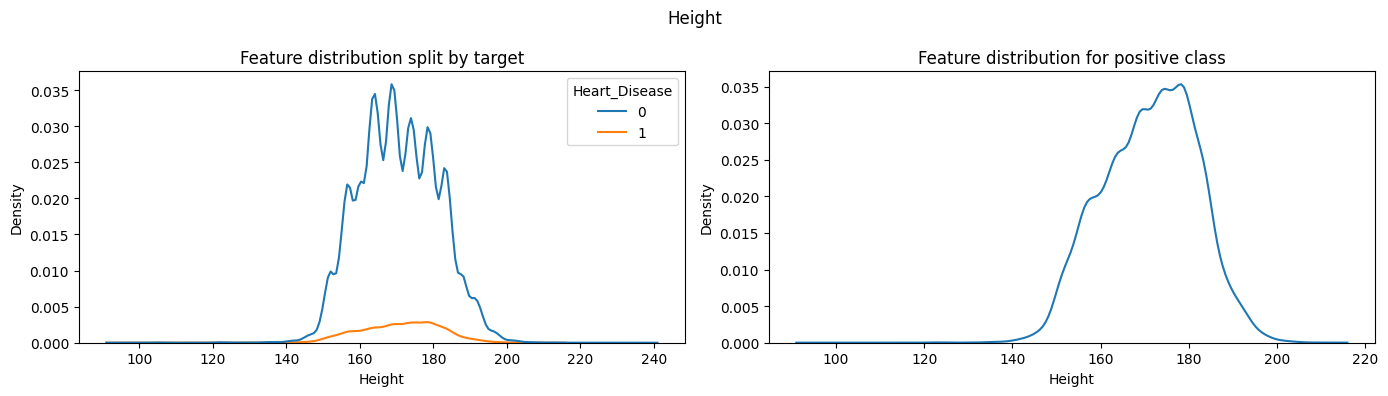

In [56]:
def plot_numerical(f, dataset):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    plt.suptitle(f'{f}')
    ax[0].set_title('Feature distribution split by target')
    sns.kdeplot(data=dataset, x=f, hue=TARGET, cut=0, bw_adjust=1.5, ax=ax[0])
    ax[1].set_title('Feature distribution for positive class')
    sns.kdeplot(data=dataset[dataset[TARGET]==1], x=f, cut=0, bw_adjust=1.5, ax=ax[1])
    fig.tight_layout()
    plt.show()
    
plot_numerical('Height', data)

In [57]:
data_clipped = data[(data.Height > 140) & (data.Height < 200)]

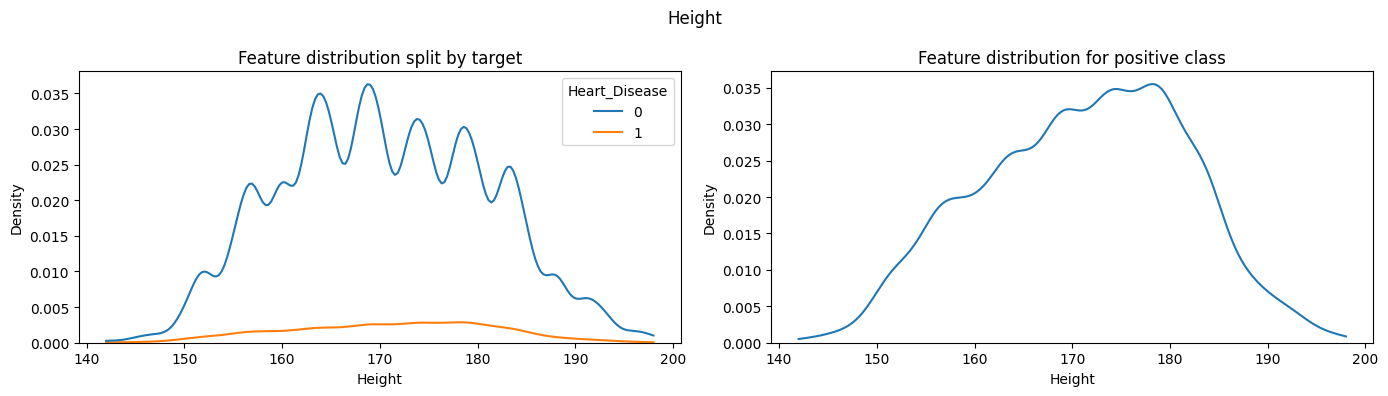

In [58]:
plot_numerical('Height', data_clipped)

In [59]:
data['Height'].corr(data[TARGET]), data_clipped['Height'].corr(data_clipped[TARGET])

(0.015778826583827194, 0.016618051300901042)

### Weight_(kg)

In [60]:
data = data.rename({'Weight_(kg)': 'Weight'}, axis=1)
data_clipped = data_clipped.rename({'Weight_(kg)': 'Weight'}, axis=1)

In [61]:
data['Weight'].nunique()

525

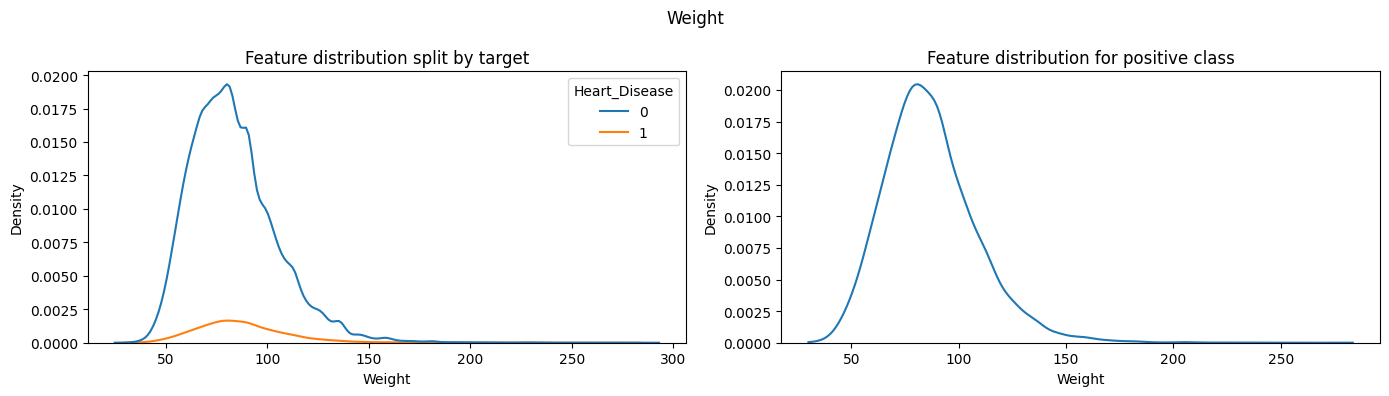

In [62]:
plot_numerical('Weight', data)

In [63]:
data_clipped = data_clipped[data_clipped.Weight < 170]

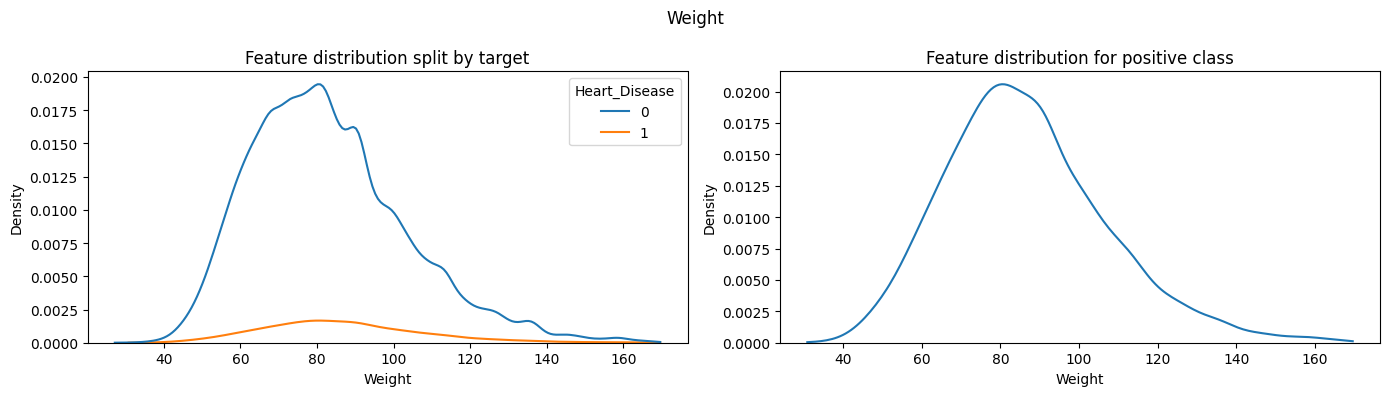

In [64]:
plot_numerical('Weight', data_clipped)

In [65]:
data['Weight'].corr(data[TARGET]), data_clipped['Weight'].corr(data_clipped[TARGET])

(0.04586944237418151, 0.04806380536603155)

### BMI

In [66]:
data['BMI'].nunique()

3654

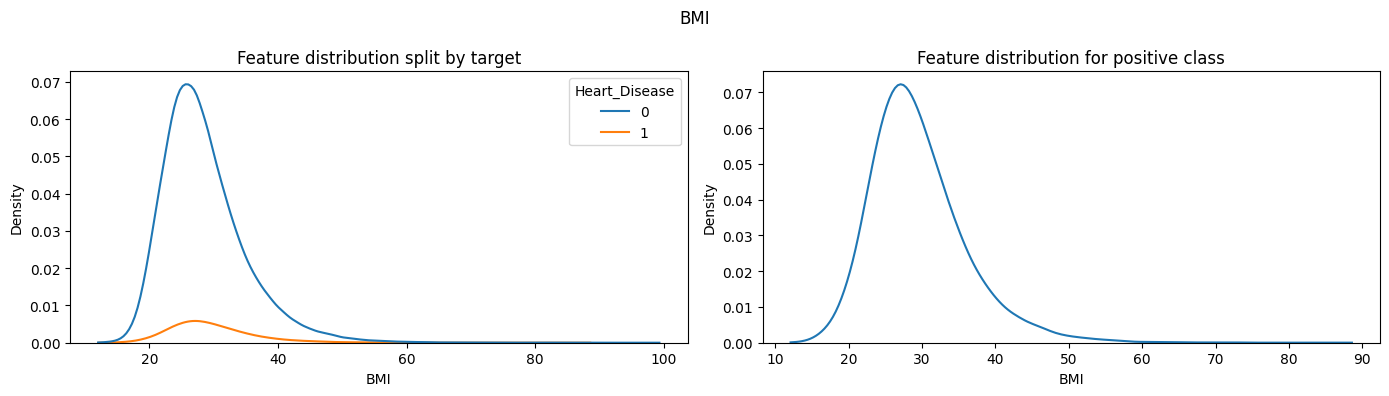

In [67]:
plot_numerical('BMI', data)

In [68]:
data_clipped = data_clipped[data_clipped.BMI < 60]

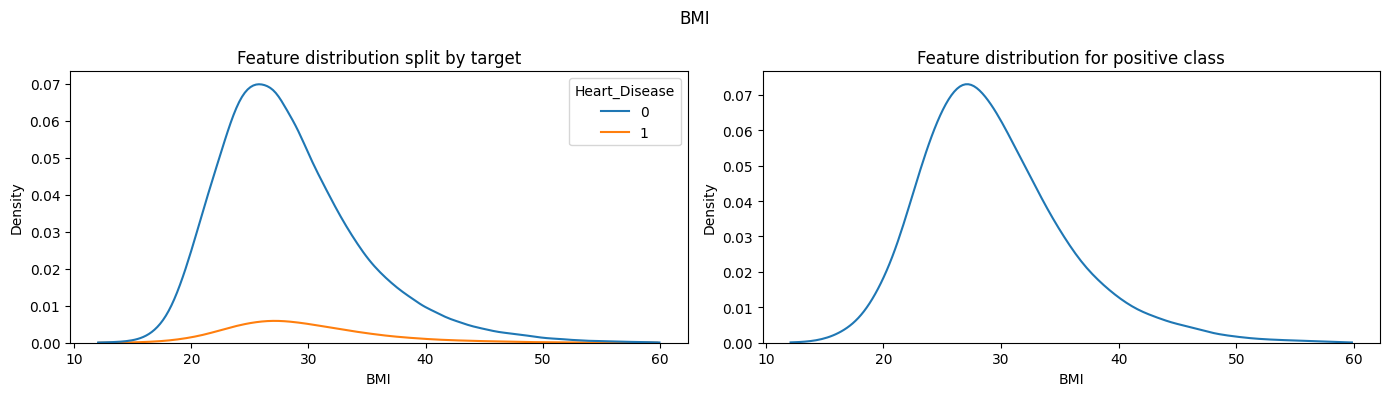

In [69]:
plot_numerical('BMI', data_clipped)

### Smoking_History

In [70]:
data['Smoking_History'].value_counts()

Smoking_History
No     183514
Yes    125255
Name: count, dtype: int64

In [71]:
data.groupby('Smoking_History')[TARGET].value_counts()

Smoking_History  Heart_Disease
No               0                173128
                 1                 10386
Yes              0                110673
                 1                 14582
Name: count, dtype: int64

In [72]:
data['Smoking_History'] = data.Smoking_History.replace(binary_mapping)
data_clipped['Smoking_History'] = data_clipped.Smoking_History.replace(binary_mapping)

In [73]:
data['Smoking_History'].corr(data[TARGET]), data_clipped['Smoking_History'].corr(data_clipped[TARGET])

(0.10774674659879675, 0.10779531828118788)

### *_Consumption

**Alcohol**

In [74]:
data['Alcohol_Consumption'].nunique()

31

In [75]:
data['Alcohol_Consumption'].unique()

array([ 0.,  4.,  3.,  8., 30.,  2., 12.,  1.,  5., 10., 20., 17., 16.,
        6., 25., 28., 15.,  7.,  9., 24., 11., 29., 27., 14., 21., 23.,
       18., 26., 22., 13., 19.])

Likely represents the number of days of alcohol consumption per month.

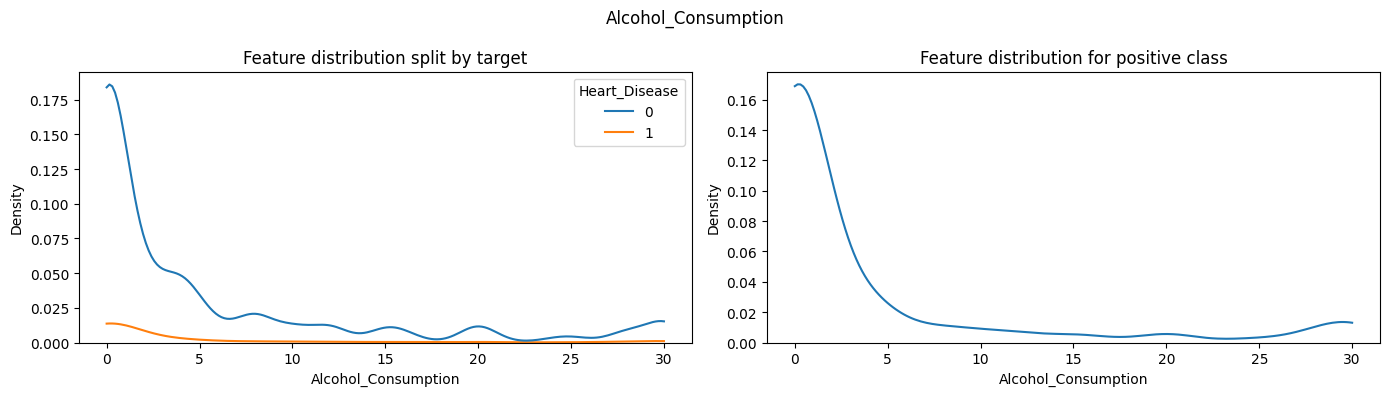

In [76]:
plot_numerical('Alcohol_Consumption', data)

Can be discretized based on low/medium/high consumption.

In [77]:
data['Alcohol_Consumption'].corr(data[TARGET]), data_clipped['Alcohol_Consumption'].corr(data_clipped[TARGET])

(-0.0365967394420938, -0.03662007813800859)

**Fruit**

In [78]:
data['Fruit_Consumption'].nunique()

77

In [79]:
data['Fruit_Consumption'].unique()

array([ 30.,  12.,   8.,  16.,   2.,   1.,  60.,   0.,   7.,   5.,   3.,
         6.,  90.,  28.,  20.,   4.,  80.,  24.,  15.,  10.,  25.,  14.,
       120.,  32.,  40.,  17.,  45., 100.,   9.,  99.,  96.,  35.,  50.,
        56.,  48.,  27.,  72.,  36.,  84.,  26.,  23.,  18.,  21.,  42.,
        22.,  11., 112.,  29.,  64.,  70.,  33.,  76.,  44.,  39.,  75.,
        31.,  92., 104.,  88.,  65.,  55.,  13.,  38.,  63.,  97., 108.,
        19.,  52.,  98.,  37.,  68.,  34.,  41., 116.,  54.,  62.,  85.])

Likely represent the number of servings per month.  
We can judge low/high consumption based on servings per day.

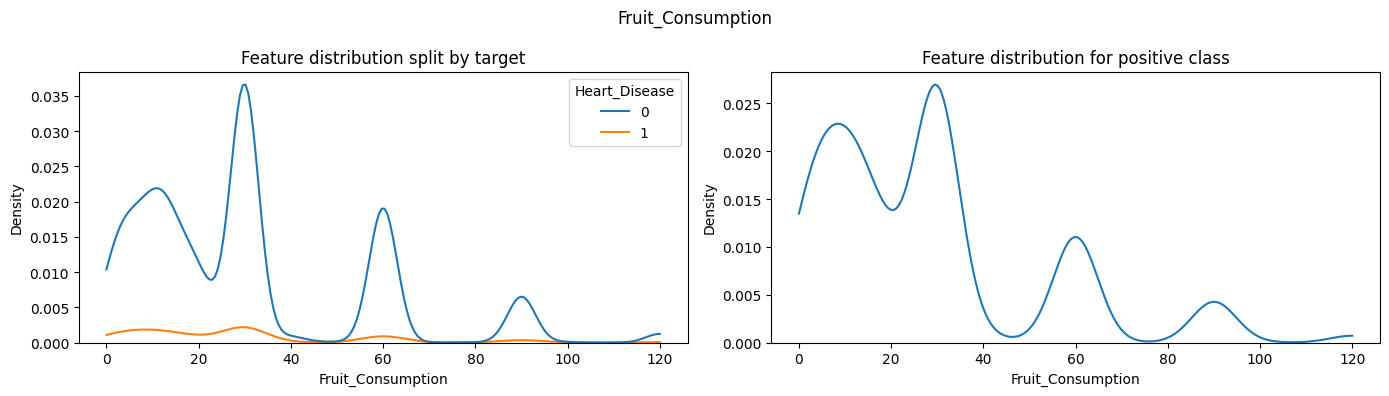

In [80]:
plot_numerical('Fruit_Consumption', data)

In [81]:
data['Fruit_Consumption'].corr(data[TARGET]), data_clipped['Fruit_Consumption'].corr(data_clipped[TARGET])

(-0.020047144135450452, -0.02036576635065168)

**Green_Vegetables**

In [82]:
data['Green_Vegetables_Consumption'].nunique()

75

In [83]:
data['Green_Vegetables_Consumption'].unique()

array([ 16.,   0.,   3.,  30.,   4.,  12.,   8.,  20.,   1.,  10.,   5.,
         2.,   6.,  60.,  28.,  25.,  14.,  40.,   7.,  22.,  24.,  15.,
       120.,  90.,  19.,  13.,  11.,  80.,  27.,  17.,  56.,  18.,   9.,
        21.,  99.,  29.,  31.,  45.,  23., 100., 104.,  32.,  48.,  75.,
        36.,  35., 112.,  26.,  50.,  33.,  96.,  52.,  76.,  84.,  34.,
        97.,  88.,  98.,  68.,  92.,  55.,  95.,  64., 124.,  61.,  65.,
        77.,  85.,  44.,  39.,  70.,  93., 128.,  37.,  53.])

Same as Fruit.

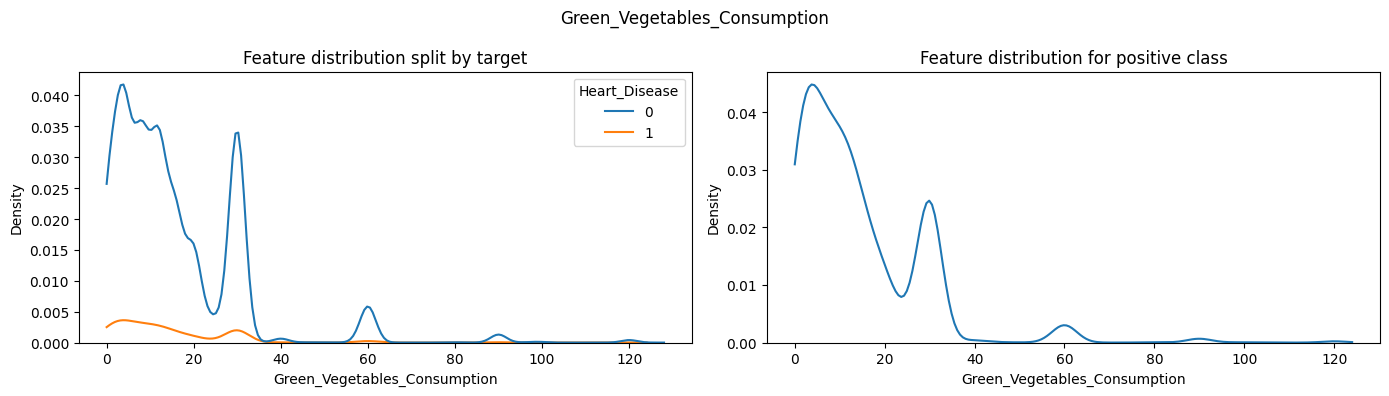

In [84]:
plot_numerical('Green_Vegetables_Consumption', data)

In [85]:
data['Green_Vegetables_Consumption'].corr(data[TARGET]), data_clipped['Green_Vegetables_Consumption'].corr(data_clipped[TARGET])

(-0.02404702257041645, -0.024214688633708722)

**FriedPotato**

In [86]:
data['FriedPotato_Consumption'].nunique()

69

In [87]:
data['FriedPotato_Consumption'].unique()

array([ 12.,   4.,  16.,   8.,   0.,   1.,   2.,  30.,  20.,  15.,  10.,
         3.,   7.,  28.,   5.,   9.,   6., 120.,  32.,  14.,  60.,  33.,
        48.,  25.,  24.,  21.,  90.,  13.,  99.,  17.,  18.,  40.,  56.,
        34.,  36.,  44., 100.,  11.,  64.,  45.,  80.,  29.,  68.,  26.,
        50.,  22.,  95.,  23.,  27., 112.,  35.,  31.,  98.,  96.,  88.,
        92.,  19.,  76.,  49.,  97., 128.,  41.,  37.,  42.,  52.,  72.,
        46., 124.,  84.])

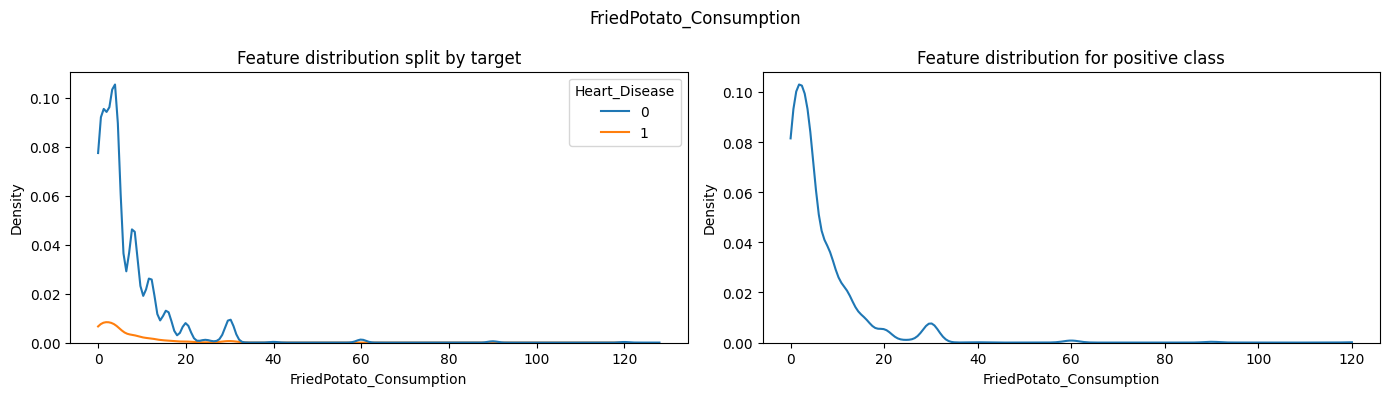

In [88]:
plot_numerical('FriedPotato_Consumption', data)

In [89]:
data['FriedPotato_Consumption'].corr(data[TARGET]), data_clipped['FriedPotato_Consumption'].corr(data_clipped[TARGET])

(-0.009242534778269156, -0.009500892628802087)

# Feature Engineering

In [90]:
original_features = [f for f in data.columns if f != TARGET]

In [91]:
def create_features(df):
    # discretize numerical features
    df['bmi_range'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=False).astype('int8')
    df['alcohol_cat'] = (df['Alcohol_Consumption'] > 5).astype('int8')
    df['fruit_cat'] = (df['Fruit_Consumption'] > 30).astype('int8')
    df['vegetables_cat'] = (df['Green_Vegetables_Consumption'] > 30).astype('int8')
    df['potato_cat'] = (df['FriedPotato_Consumption'] > 15).astype('int8')
    
    # actions which reduce disease risk
    df['good_habits'] = df['Exercise'] + df['fruit_cat'] + df['vegetables_cat']
    
    # actions which increase disease risk
    df['bad_habits'] = df['Smoking_History'] + df['alcohol_cat'] + df['potato_cat']
    
    # co-morbities
    df['comorbities'] = df['Skin_Cancer'] + df['Other_Cancer'] + df['Depression'] + df['Arthritis'] + df['Diabetes']
    
    # health status
    df['health_status'] = df['General_Health'] + df['Checkup']
    
    return df

In [92]:
data = create_features(data.copy())
data_clipped = create_features(data_clipped.copy())

# Feature selection

In [93]:
extended_features = [f for f in data.columns if f != TARGET]

In [94]:
numerical_features = [
    'Age_Category', 
    'Height', 
    'Weight', 
    'BMI', 
    'Alcohol_Consumption', 
    'Fruit_Consumption',
    'Green_Vegetables_Consumption',
    'FriedPotato_Consumption',
    'good_habits',
    'bad_habits',
    'comorbities',
    'health_status'
]

categorical_features = [f for f in extended_features if f not in numerical_features]

### Correlation

In [95]:
def plot_heatmap(df, size=14):
    plt.figure(figsize=(size, size * 0.75))
    sns.heatmap(
        data=df, 
        mask=np.triu(np.ones_like(df)),
        vmin=-1, vmax=1, center=0,
        annot=True, linewidths=0.1,
        fmt='.2f', annot_kws={'fontsize': 8})
    plt.show()

**Pearson correlation**

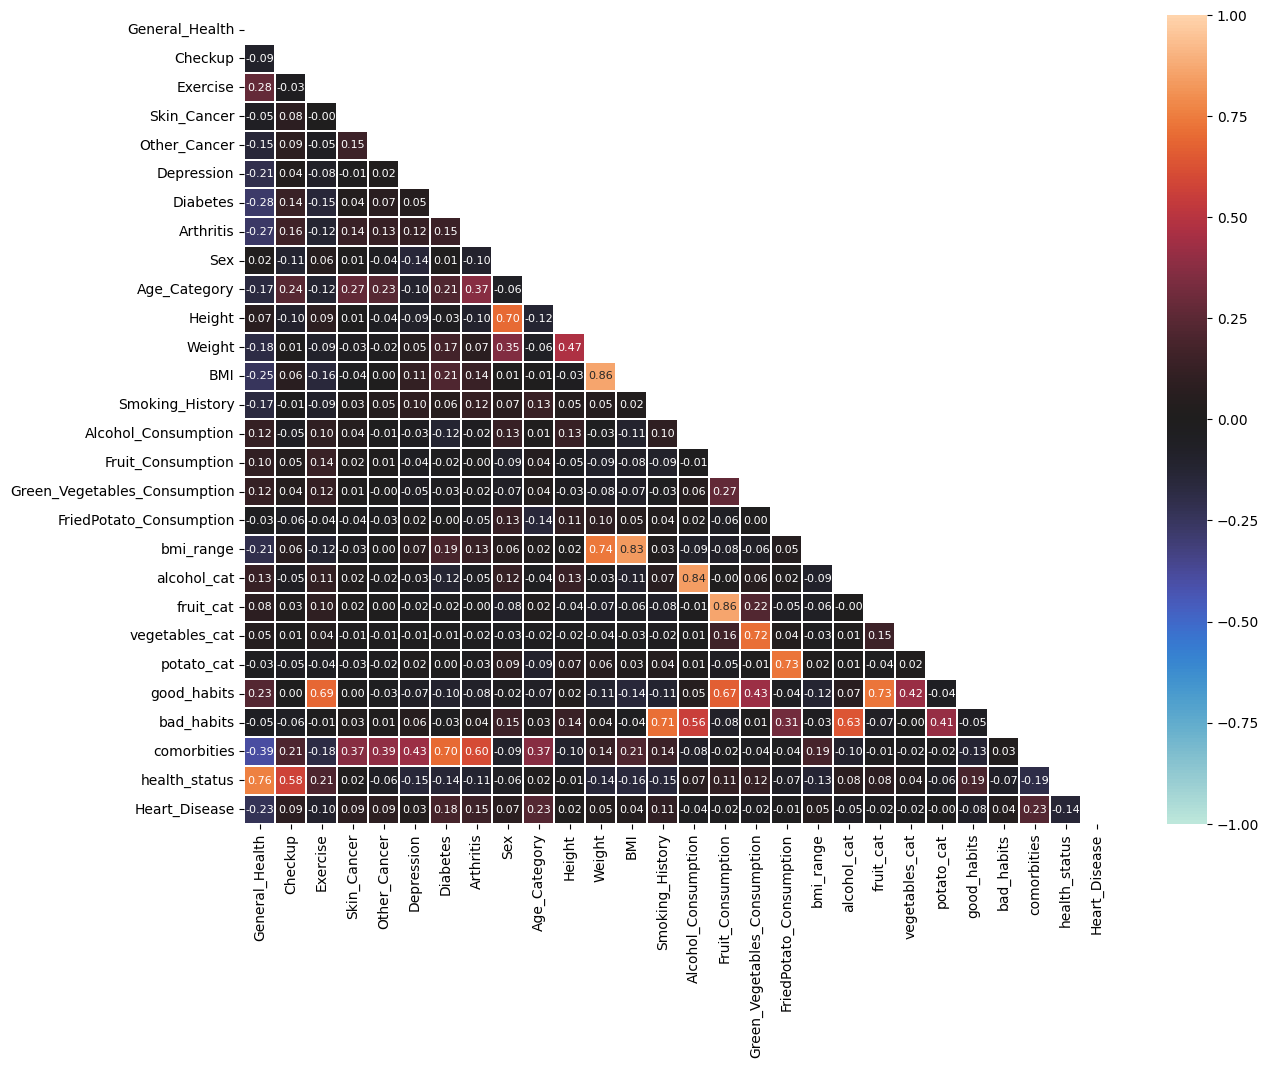

In [96]:
corr_df = data[extended_features + [TARGET]].corr(method='pearson')
plot_heatmap(corr_df)

**Spearman's rank correlation:**

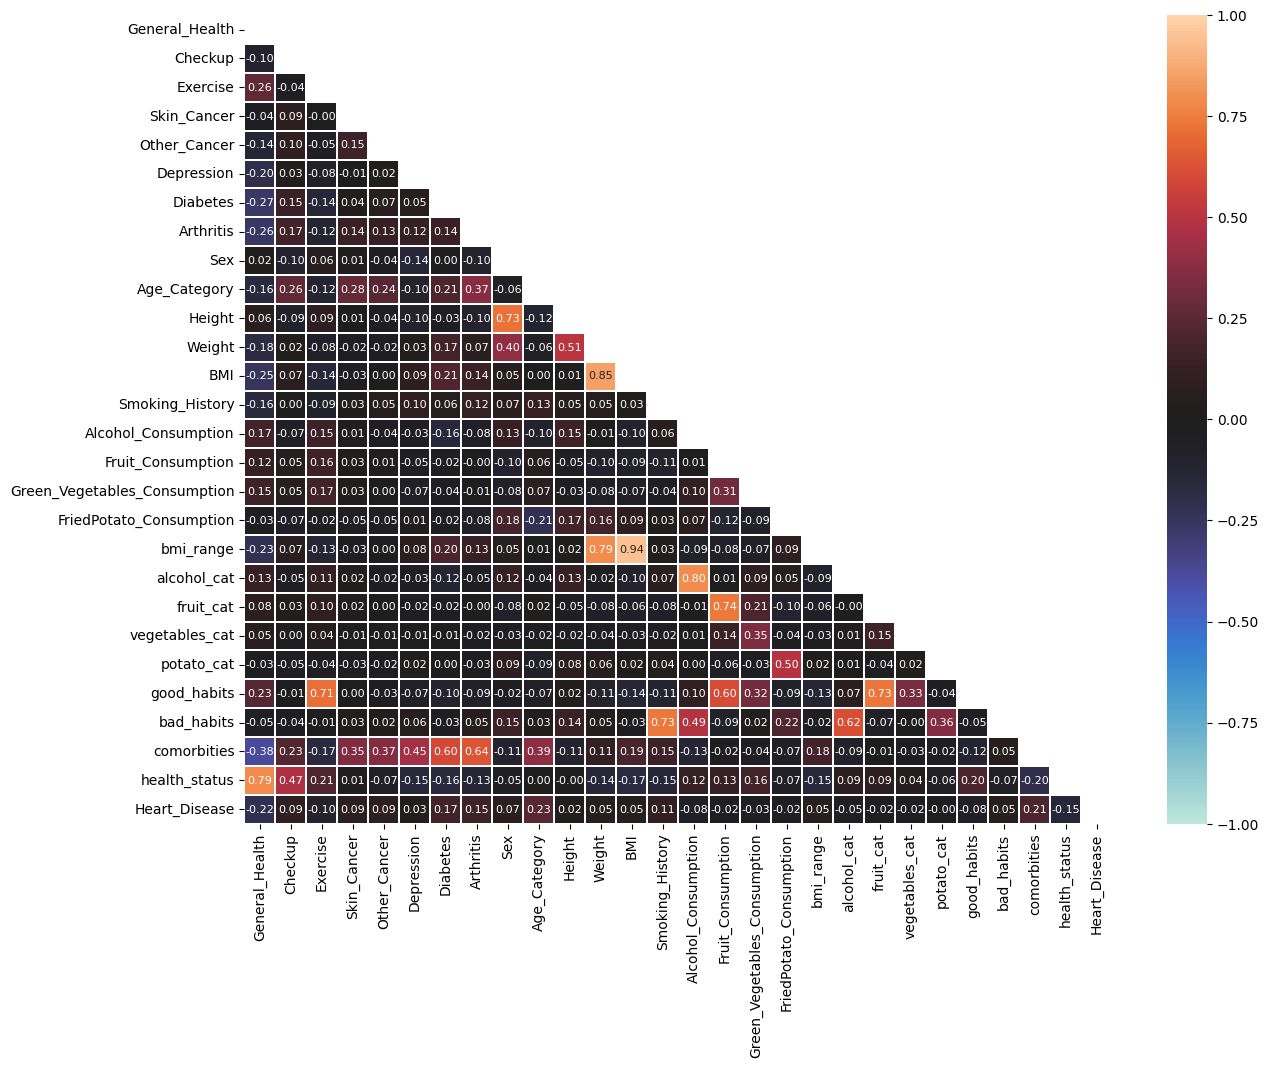

In [97]:
corr_df = data[extended_features + [TARGET]].corr(method='spearman')
plot_heatmap(corr_df)

**Kendall Tau correlation**

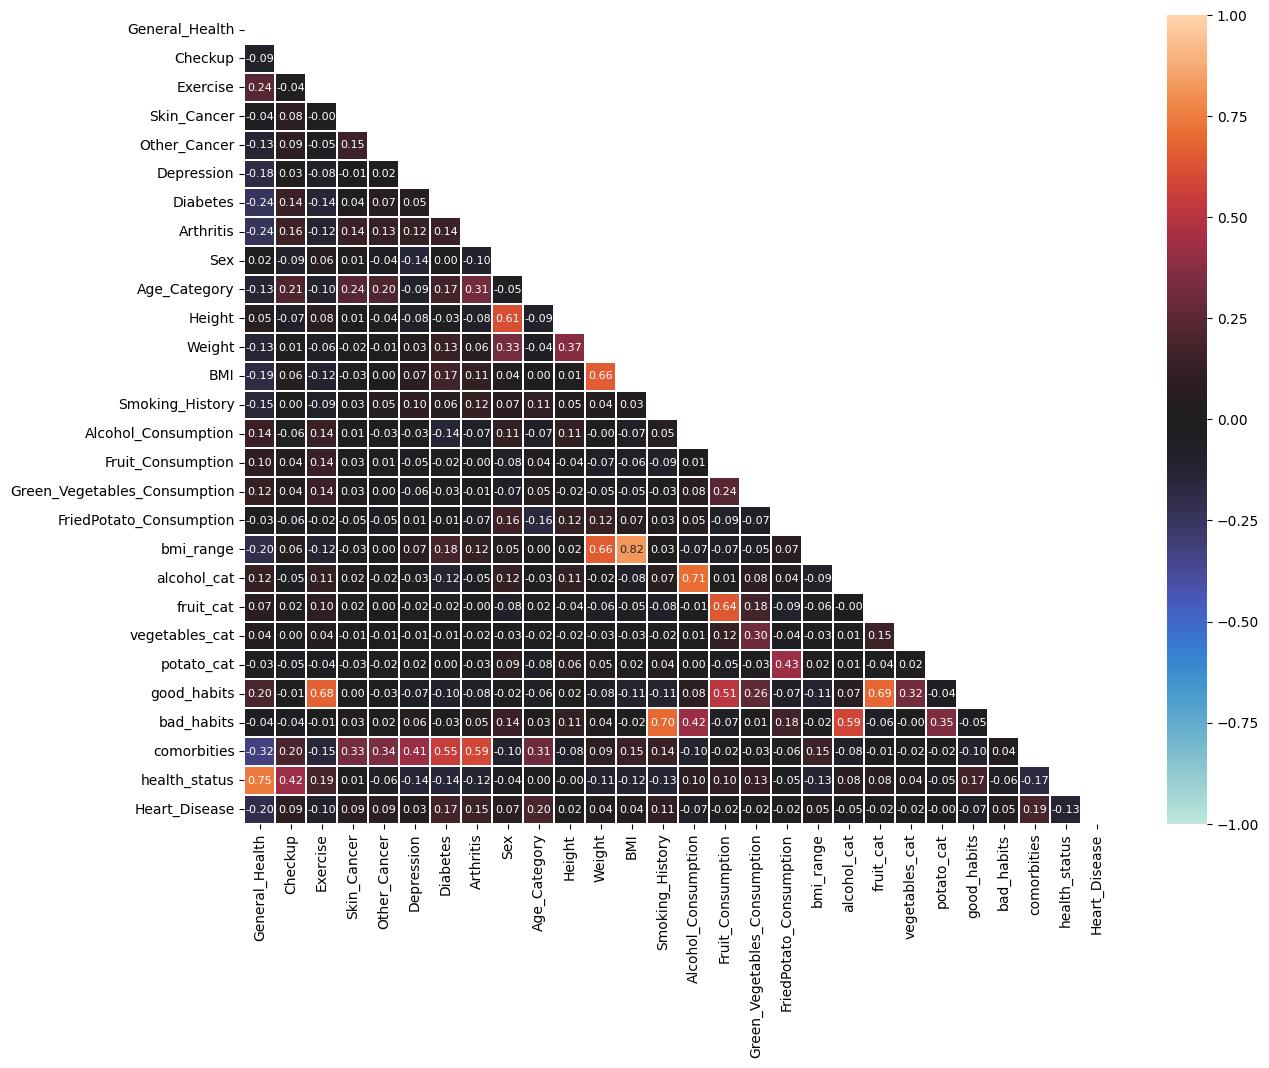

In [98]:
corr_df = data[extended_features + [TARGET]].corr(method='kendall')
plot_heatmap(corr_df)

### Selected features

In [99]:
selected_features = [
    'General_Health',
    'Exercise',
    'Diabetes',
    'Arthritis',
    'Age_Category',
    'Smoking_History',
    'comorbities',
    'health_status'
]

# Modeling framework

**Creating holdout set for testing model performance:**

In [100]:
train, test, _, _ = train_test_split(
    data, data[TARGET], 
    stratify=data[TARGET], 
    test_size=0.1, 
    shuffle=True, 
    random_state=SEED)

**Feature sets:**

In [101]:
feature_sets = {
    'Original': original_features,
    'Extended': extended_features,
    'Selected': selected_features
}

**Cross-validation + Threshold-tuning:**

* Correctly predicting all cases with risk of heart disease is critical in this problem -> Recall is more important than precision.
* Hence, metric used for tuning the model: f-beta score with beta = 2 (recall is weighted twice that of precision)

In [102]:
def fit_model(estimator, feature_set):
    fbeta = make_scorer(fbeta_score, beta=2)
    skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=SEED)

    tuned_model = TunedThresholdClassifierCV(
        estimator=estimator,
        scoring=fbeta,
        response_method='auto',
        thresholds=100,
        cv=skf,
        refit=True,
        n_jobs=-1,
        random_state=0
    ).fit(train[feature_set], train[TARGET])

    return tuned_model

In [103]:
def evaluate_model(model, feature_set):
    predictions = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], predictions)
    recall = recall_score(test[TARGET], predictions)
    f2 = fbeta_score(test[TARGET], predictions, beta=2)
    print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], predictions, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()

In [104]:
def save_model(model, config):
    save_path = f'{config}.joblib'
    joblib.dump(model, save_path)

In [105]:
def run_experiment(model, model_name):
    for fname, fset in feature_sets.items():
        print('-' * 40)
        print(f'Feature set: {fname}')
        start_time = time.time()
        tuned_model = fit_model(model, fset)
        evaluate_model(tuned_model, fset)
        end_time = time.time()
        print(f'Time taken: {end_time - start_time:.2f} secs\n')
        save_model(tuned_model, f'{model_name}_fs{fname}')

# Logistic Regression

----------------------------------------
Feature set: Original
Accuracy: 0.7629, Recall: 0.7421



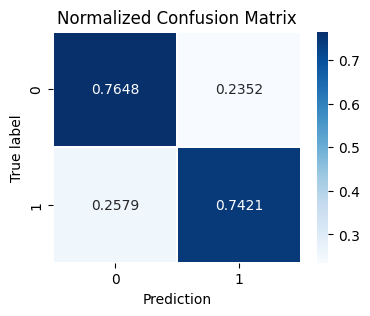

Time taken: 6.84 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7627, Recall: 0.7441



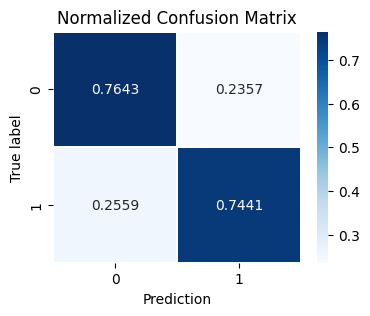

Time taken: 5.79 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7266, Recall: 0.7809



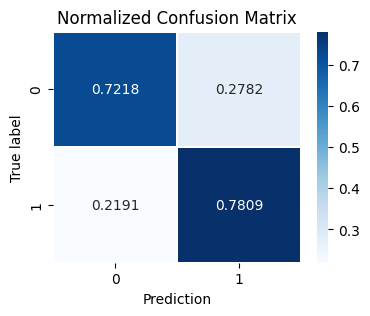

Time taken: 4.71 secs



In [106]:
model = make_pipeline(
    StandardScaler(), 
    LogisticRegression(C=0.01, class_weight='balanced', random_state=SEED)
)

run_experiment(model, 'logisticreg')

# Decision Tree

----------------------------------------
Feature set: Original
Accuracy: 0.7276, Recall: 0.7861



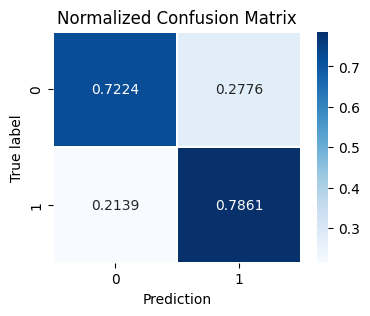

Time taken: 8.38 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7409, Recall: 0.7669



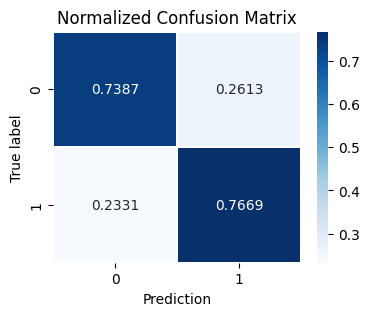

Time taken: 9.72 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7552, Recall: 0.7361



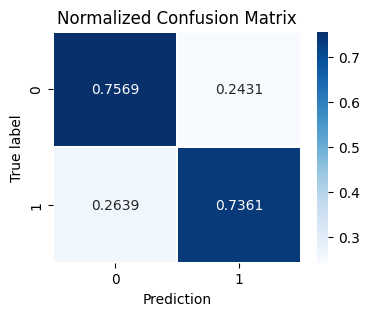

Time taken: 5.37 secs



In [107]:
model = DecisionTreeClassifier(
    max_depth=7, 
    class_weight='balanced', 
    random_state=SEED
)

run_experiment(model, 'decisiontree')

# Random Forest

----------------------------------------
Feature set: Original
Accuracy: 0.7397, Recall: 0.7733



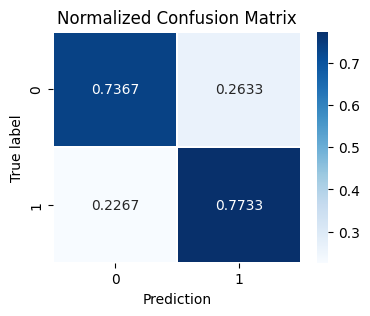

Time taken: 171.40 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7410, Recall: 0.7661



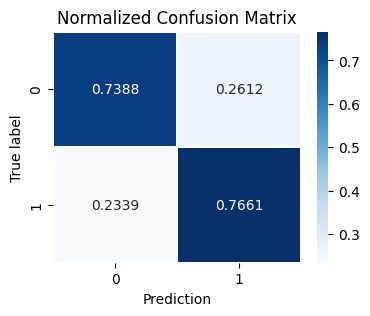

Time taken: 180.36 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7480, Recall: 0.7405



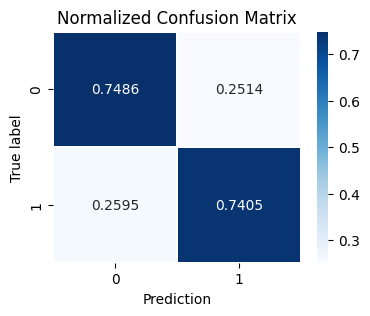

Time taken: 84.54 secs



In [108]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=7, 
    class_weight='balanced', 
    random_state=SEED
)

run_experiment(model, 'randomforest')

# AdaBoost

----------------------------------------
Feature set: Original
Accuracy: 0.7603, Recall: 0.7449



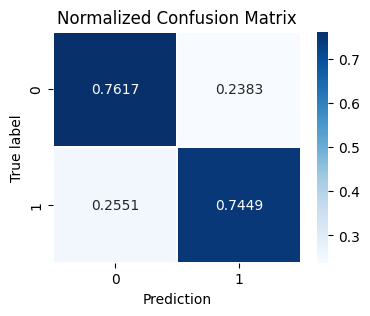

Time taken: 133.56 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7499, Recall: 0.7625



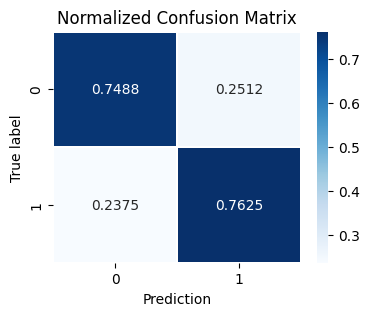

Time taken: 160.42 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7476, Recall: 0.7533



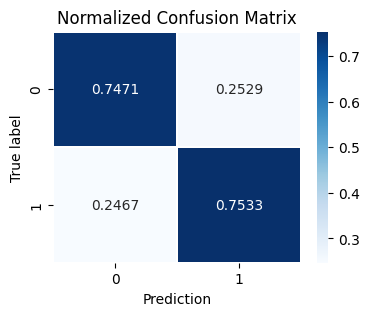

Time taken: 31.29 secs



In [109]:
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=7, 
        class_weight='balanced',
        random_state=SEED
    ),
    n_estimators=50,
    learning_rate=0.1,
    algorithm='SAMME',
    random_state=SEED
)

run_experiment(model, 'adaboost')

# Multi-layer Perceptron

----------------------------------------
Feature set: Original
Accuracy: 0.7691, Recall: 0.7281



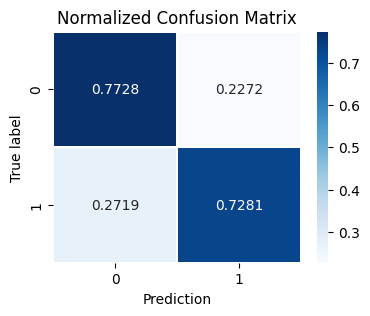

Time taken: 249.06 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7326, Recall: 0.7901



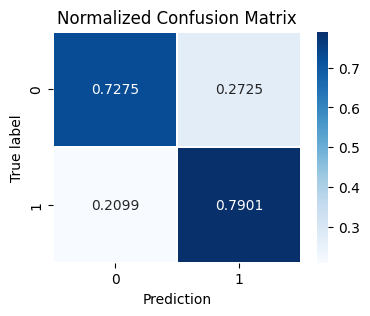

Time taken: 249.64 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7486, Recall: 0.7505



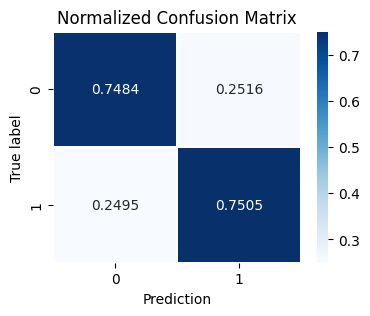

Time taken: 229.31 secs



In [110]:
classifier = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation='relu',
    solver='adam',
    alpha=1e-2,
    learning_rate_init=0.001,
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=50,
    tol=1e-4,
    random_state=SEED
)

model = make_pipeline(StandardScaler(), classifier)

run_experiment(model, 'mlpnn')

# HistGradientBoosting

In [111]:
train[categorical_features] = train[categorical_features].astype('category')
test[categorical_features] = test[categorical_features].astype('category')

----------------------------------------
Feature set: Original
Accuracy: 0.7598, Recall: 0.7349



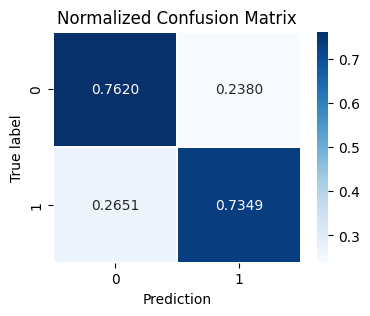

Time taken: 69.14 secs

----------------------------------------
Feature set: Extended
Accuracy: 0.7563, Recall: 0.7473



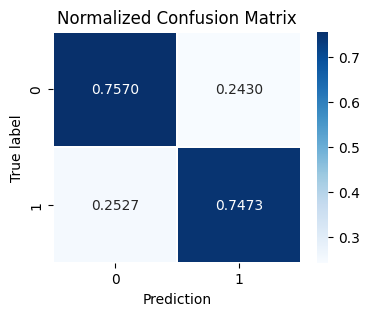

Time taken: 70.33 secs

----------------------------------------
Feature set: Selected
Accuracy: 0.7440, Recall: 0.7585



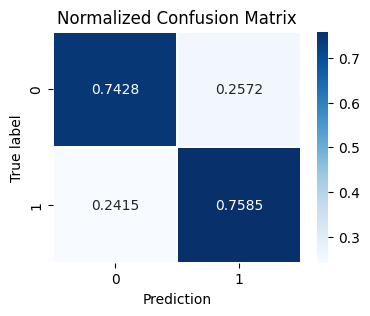

Time taken: 60.08 secs



In [112]:
model = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=1000,
    categorical_features='from_dtype',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=100,
    tol=2e-4,
    scoring=make_scorer(fbeta_score, beta=2),
    class_weight='balanced', 
    random_state=SEED
)

run_experiment(model, 'histgradient')